In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#paramètres
m = 1000           # kg, masse véhicule (voir table 4)
g = 9.81           # gravité
rhoCD=0.30       # 0.5.rho.CD=...
A_f = 1.8          # m², surface frontale (table 4)
eta_T = 0.95       # rendement transmission (table 2)
distance_km = 7.2
Pe = 75  # kW

diesel_ratio = 0.5075
essence_ratio = 0.4925


params = {
    "diesel": {"eta0": 0.40, "HL": 36e6},
    "essence": {"eta0": 0.30, "HL": 32e6}
}


#données
data_fev25 = pd.DataFrame({
    "heure": list(range(24)),
    "vitesse": [54.2, 56.2, 55.4, 55.3, 56.7, 56.9, 53.2, 40.9, 29.6, 29.1, 36.5, 42.5,
                40.5, 41.7, 40.8, 38.0, 33.2, 27.2, 27.1, 31.2, 40.4, 48.7, 50.4, 51.0],
    "debit": [3759, 2357, 1683, 1463, 2060, 3844, 7946, 10053, 9848, 9645, 9686, 9967,
              10108, 10057, 10111, 9904, 9632, 9206, 9187, 9478, 8722, 7073, 6247, 5920],
    "mois": "Février 2025"
})

data_fev24 = pd.DataFrame({
    "heure": list(range(24)),
    "vitesse": [62.6, 68.1, 68.3, 67.7, 67.8, 68.3, 64.9, 48.1, 32.2, 31.2, 42.0, 46.5,
                45.4, 40.8, 40.9, 36.3, 32.0, 27.2, 26.0, 30.2, 38.6, 58.2, 59.4, 60.6],
    "debit": [4197, 2595, 1813, 1565, 2214, 4334, 8775, 10642, 10292, 10190, 10241, 10495,
              10518, 10284, 10261, 9904, 9632, 9375, 9407, 9878, 9562, 7843, 6863, 6376],
    "mois": "Février 2024"
})

data_avril25 = pd.DataFrame({
    "heure": list(range(24)),
    "vitesse": [51.4, 55.9, 57.1, 57.4, 58.4, 58.3, 53.8, 39.0, 28.6, 28.4, 37.5, 39.1,
                37.6, 35.7, 36.1, 33.5, 29.8, 25.4, 24.4, 27.0, 35.6, 46.7, 47.7, 48.4],
    "debit": [4440, 2723, 1871, 1565, 2105, 3904, 8043, 9844, 9590, 9471, 9518, 9788,
              9976, 9920, 9890, 9758, 9391, 9027, 8989, 9373, 9062, 7537, 6474, 6447],
    "mois": "Avril 2025"
})

data_avril24 = pd.DataFrame({
    "heure": list(range(24)),
    "vitesse": [63.3, 67.2, 68.7, 69.8, 70.2, 70.2, 65.1, 45.2, 32.7, 33.0, 41.5, 43.5,
                42.1, 38.5, 40.0, 38.1, 32.7, 28.3, 28.7, 32.7, 42.9, 59.3, 60.8, 60.9],
    "debit": [4911, 2965, 1871, 1565, 2179, 4322, 8791, 10481, 10264, 10057, 10013, 10245,
              10528, 10257, 10294, 10213, 9828, 9550, 9663, 10113, 9307, 7599, 6863, 6605],
    "mois": "Avril 2024"
})


In [3]:

def mu_P_essence(x):
    return 0.234+ 1.0592 * x  + 0.8149 * x**2- 1.2121 * x**3 

def mu_P_diesel(x):
    return 0.5968- 0.1666 * x + 2.4968 * x**2 - 2.1128 * x**3 
def mu_n(x):
    """Coefficient mu_n, dépendant aussi de Pi/Pe selon approximation Table 1"""
    return 0.7107 + 0.9963 * x - 1.0582 * x**2 + 0.3124 * x**3

def conso_l_km_dyn_muP(v_kmh, eta0, HL, Pe, fuel_type):
    v = v_kmh * 1000 / 3600  # m/s
    f_r = 0.0136 + 0.4e-7 * v**2
    P_rl = m * g * f_r * v
    P_w = rhoCD * A_f * v**3
    P_i = (P_rl + P_w) / eta_T
    
    Pi_Pe = P_i / (Pe * 1000)  # Pe en kW → W
    Pi_Pe = np.clip(Pi_Pe, 0, 1)  # éviter dépassement hors plage
    muN = mu_n(Pi_Pe)
    if fuel_type == "essence":
        mu_P = mu_P_essence(Pi_Pe)
    else:
        mu_P = mu_P_diesel(Pi_Pe)

    eta = eta0 * mu_P * muN
    t = 1000 / v
    E = P_i * t / eta
    return E / HL




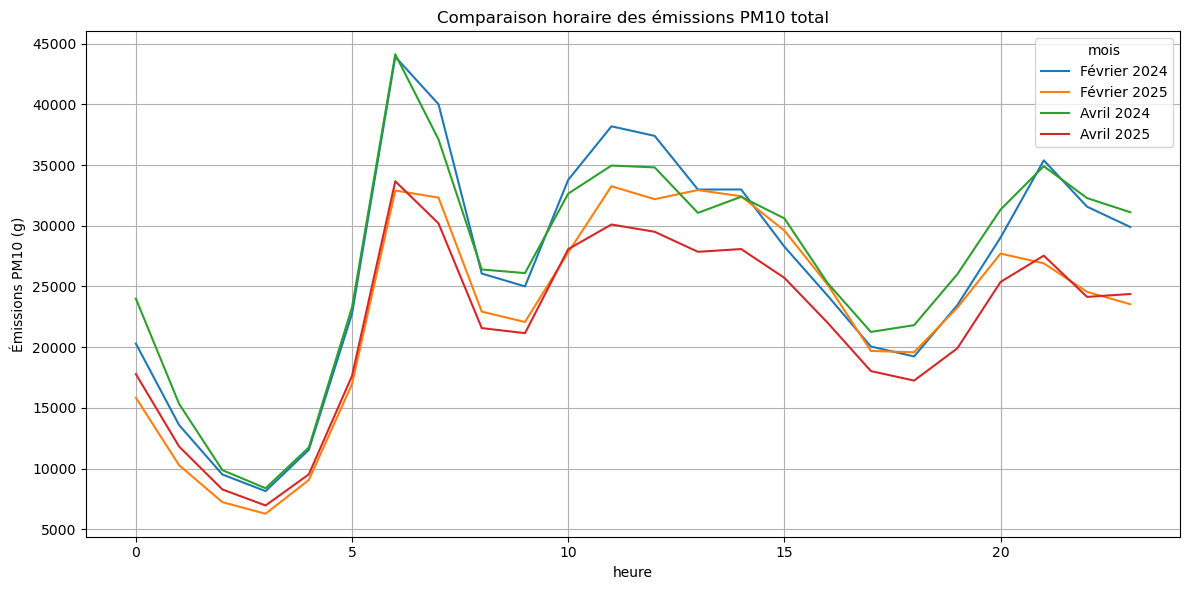

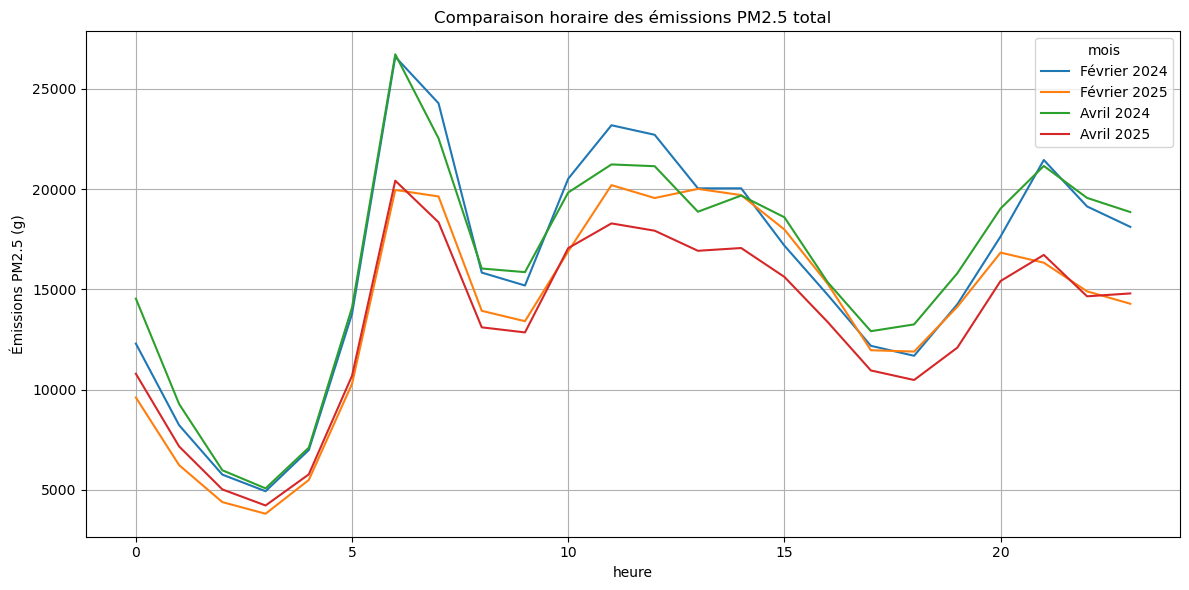

In [4]:


# PM10 ET PM2.5
def speed_correction(v):
    if v < 40:
        return 1.39
    elif v <= 90:
        return -0.00974 * v + 1.78
    else:
        return 0.902

# Réimportation nécessaire après reset
def complete_calculations(df):
    df = df.copy()

    # Calcul du temps de parcours et du nombre de véhicules
    df["temps_parcours_h"] = distance_km / df["vitesse"]
    df["nb_voitures"] = df["debit"] / df["temps_parcours_h"]

    # Application du modèle de consommation pour chaque carburant
    for fuel in ["diesel", "essence"]:
        eta0 = params[fuel]["eta0"]
        HL = params[fuel]["HL"]
        df[f"conso_{fuel}"] = df["vitesse"].apply(
            lambda v: conso_l_km_dyn_muP(v, eta0, HL, Pe, fuel)
        )
        # Consommation en litres par heure = conso (L/km) * nb_voitures * distance
        df[f"{fuel}_litres"] = df[f"conso_{fuel}"] * df["nb_voitures"] * distance_km

    # PM non-exhaust
    EF_tsp_tyre = 0.0107
    EF_tsp_brake = 0.0122
    EF_tsp_road = 0.0150
    PM10_frac = 0.6
    PM2_5_frac = 0.42

    df["Sr_v"] = df["vitesse"].apply(speed_correction)

    df["PM10_tyre"] = df["Sr_v"] * EF_tsp_tyre * PM10_frac * df["nb_voitures"] * distance_km
    df["PM10_road"] = EF_tsp_road * PM10_frac * df["nb_voitures"] * distance_km
    df["PM2.5_tyre"] = df["Sr_v"] * EF_tsp_tyre * PM2_5_frac * df["nb_voitures"] * distance_km
    df["PM2.5_road"] = EF_tsp_road * PM2_5_frac * df["nb_voitures"] * distance_km

    df["PM10_brake"] = EF_tsp_brake * PM10_frac * df["nb_voitures"] * distance_km
    df["PM2.5_brake"] = EF_tsp_brake * PM2_5_frac * df["nb_voitures"] * distance_km

    df["PM10_non_exhaust"] = df["PM10_tyre"] + df["PM10_brake"] + df["PM10_road"]
    df["PM2.5_non_exhaust"] = df["PM2.5_tyre"] + df["PM2.5_brake"] + df["PM2.5_road"]

    # PM exhaust — Facteurs d'émission (mg/km)
    EF_PM10 = {"diesel": 79.77, "essence": 26.26}
    EF_PM2_5 = {"diesel": 57.8, "essence": 1.57}

    df["PM10_exhaust"] = (
        EF_PM10["diesel"] * df["nb_voitures"] * diesel_ratio +
        EF_PM10["essence"] * df["nb_voitures"] * essence_ratio
    ) * distance_km / 1000  # mg → g

    df["PM2.5_exhaust"] = (
        EF_PM2_5["diesel"] * df["nb_voitures"] * diesel_ratio +
        EF_PM2_5["essence"] * df["nb_voitures"] * essence_ratio
    ) * distance_km / 1000  # mg → g

    # Total PM
    df["PM10_total"] = df["PM10_non_exhaust"] + df["PM10_exhaust"]
    df["PM2.5_total"] = df["PM2.5_non_exhaust"] + df["PM2.5_exhaust"]

    return df


df_all = pd.concat([
    complete_calculations(data_fev24),
    complete_calculations(data_fev25),
    complete_calculations(data_avril24),
    complete_calculations(data_avril25)
]).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x="heure", y="PM10_total", hue="mois")
plt.title("Comparaison horaire des émissions PM10 total")
plt.ylabel("Émissions PM10 (g)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x="heure", y="PM2.5_total", hue="mois")
plt.title("Comparaison horaire des émissions PM2.5 total")
plt.ylabel("Émissions PM2.5 (g)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
df_all.head(50)

,heure,vitesse,debit,mois,temps_parcours_h,nb_voitures,conso_diesel,diesel_litres,conso_essence,essence_litres,...,PM2.5_tyre,PM2.5_road,PM10_brake,PM2.5_brake,PM10_non_exhaust,PM2.5_non_exhaust,PM10_exhaust,PM2.5_exhaust,PM10_total,PM2.5_total
0,0,62.6,4197,Février 2024,0.115016,36490.583333,0.046746,12281.551514,0.133091,34967.178452,...,1381.766531,1655.21286,1923.199704,1346.239793,6261.741692,4383.219184,14034.188583,7910.006094,20295.930275,12293.225278
1,1,68.1,2595,Février 2024,0.105727,24544.375000,0.050457,8916.693355,0.137039,24217.494757,...,886.862704,1113.33285,1293.586740,905.510718,4151.008961,2905.706272,9439.706246,5320.445389,13590.715207,8226.151661
2,2,68.3,1813,Février 2024,0.105417,17198.319444,0.050593,6264.794250,0.137166,16984.932058,...,620.343411,780.11577,906.420228,634.494160,2907.076201,2034.953340,6614.431350,3728.052533,9521.507551,5763.005873
3,3,67.7,1565,Février 2024,0.106352,14715.347222,0.050185,5317.115113,0.136783,14492.176132,...,533.565170,667.48815,775.557660,542.890362,2491.348117,1743.943682,5659.486342,3189.822567,8150.834459,4933.766249
4,4,67.8,2214,Février 2024,0.106195,20848.500000,0.050253,7543.414710,0.136847,20542.016136,...,755.290686,945.68796,1098.799344,769.159541,3528.768839,2470.138187,8018.281813,4519.296404,11547.050652,6989.434592
5,5,68.3,4334,Février 2024,0.105417,41112.805556,0.050593,14976.071858,0.137166,40602.700242,...,1482.938964,1864.87686,2166.809304,1516.766513,6949.403339,4864.582337,15811.883879,8911.957902,22761.287218,13776.540239
6,6,64.9,8775,Février 2024,0.110940,79096.875000,0.048289,27500.395379,0.134849,76796.329983,...,2937.778912,3587.83425,4168.721700,2918.105190,13491.026217,9443.718352,30420.463547,17145.704621,43911.489763,26589.422972
7,7,48.1,10642,Février 2024,0.149688,71094.472222,0.037629,19261.714672,0.119300,61067.429487,...,3016.974787,3224.84526,3746.963064,2622.874145,12663.848846,8864.694192,27342.759124,15411.036414,40006.607970,24275.730607
8,8,32.2,10292,Février 2024,0.223602,46028.111111,0.029671,9833.142770,0.102572,33992.701123,...,2070.158116,2087.83512,2425.865568,1698.105898,8365.855905,5856.099134,17702.298304,9977.440921,26068.154209,15833.540055
9,9,31.2,10190,Février 2024,0.230769,44156.666667,0.029263,9303.403330,0.101605,32303.066973,...,1985.988120,2002.94640,2327.232960,1629.063072,8025.710846,5617.997592,16982.545375,9571.770866,25008.256221,15189.768458


In [6]:

# Compilation dans un dictionnaire
datasets = {
    "Février 2024": data_fev24,
    "Février 2025": data_fev25,
    "Avril 2024": data_avril24,
    "Avril 2025": data_avril25
}

# Facteurs d'émission par litre (en g)
facteurs_emission = {
    "CO2": {"diesel": 2612, "essence": 2019},  # en g/L #modifier trop bizarre les valeurs 
    "NOx": {"diesel": 11, "essence": 13}   # en mg/L → converti en g/L
}

# Résultats finaux
resultats = []

for nom_mois, df in datasets.items():
    df_calc = complete_calculations(df)
    diesel_total = df_calc["diesel_litres"].sum()
    essence_total = df_calc["essence_litres"].sum()
    total_litres = diesel_total + essence_total

    # Nombre total de voitures
    df_calc["temps_parcours_h"] = distance_km / df_calc["vitesse"]
    df_calc["nb_voitures"] = df_calc["debit"] / df_calc["temps_parcours_h"]
    total_voitures = df_calc["nb_voitures"].sum()

    # Emissions CO2 et NOx (en kg)
    #df_pm = df_all.groupby("mois")[["PM10_total", "PM2.5_total"]].sum().reset_index()
    #df_resultats = df_resultats.merge(df_pm, on="mois", how="left")
    CO2_total = (diesel_total * facteurs_emission["CO2"]["diesel"] +
                 essence_total * facteurs_emission["CO2"]["essence"]) / 1000

    NOx_total = (diesel_total * facteurs_emission["NOx"]["diesel"] +
                 essence_total * facteurs_emission["NOx"]["essence"]) / 1000
    PM10_total = df_calc["PM10_total"].sum()
    PM25_total = df_calc["PM2.5_total"].sum()

    resultats.append({
        "mois": nom_mois,
        "diesel_litres": diesel_total,
        "essence_litres": essence_total,
        "total_litres": total_litres,
        "nb_voitures": total_voitures,
        "CO2_total_kg": CO2_total,
        "NOx_total_kg": NOx_total,
        "PM10_total_g": PM10_total,
        "PM2.5_total_g": PM25_total
    })

# Résumé en DataFrame
df_resultats = pd.DataFrame(resultats)


In [7]:
df_resultats.head()

,mois,diesel_litres,essence_litres,total_litres,nb_voitures,CO2_total_kg,NOx_total_kg,PM10_total_g,PM2.5_total_g
0,Février 2024,309941.035770,962937.631898,1.272879e+06,1.134197e+06,2.753737e+06,15927.540608,637385.443022,386681.335608
1,Février 2025,244150.031332,796184.143703,1.040334e+06,9.826614e+05,2.245216e+06,13036.044213,554584.762916,336668.884460
2,Avril 2024,315538.009572,977773.142363,1.293311e+06,1.150982e+06,2.798309e+06,16181.968956,646857.225209,392431.191875
3,Avril 2025,226694.285199,744232.490338,9.709268e+05,9.329557e+05,2.094731e+06,12168.659512,526626.824593,319705.382793


18.466592285213917


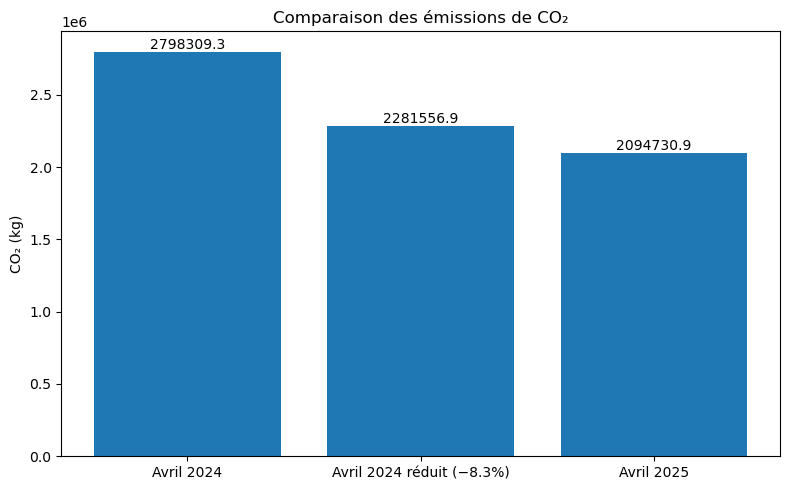

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


fev24 = df_resultats[df_resultats["mois"] == "Février 2024"].iloc[0]
fev25 = df_resultats[df_resultats["mois"] == "Février 2025"].iloc[0]
avr24 = df_resultats[df_resultats["mois"] == "Avril 2024"].iloc[0]
avr25 = df_resultats[df_resultats["mois"] == "Avril 2025"].iloc[0]

# Calcul du pourcentage de réduction entre février 2024 et février 2025
reduction_fev = 100 * (fev24["CO2_total_kg"] - fev25["CO2_total_kg"]) / fev24["CO2_total_kg"]
print(reduction_fev)

avr24_reduit = avr24["CO2_total_kg"] * (1 - reduction_fev / 100)

# Construction du DataFrame pour le graphique
df_graph = pd.DataFrame({
    "Type": ["Avril 2024", "Avril 2024 réduit (−8.3%)", "Avril 2025"],
    "CO2 (kg)": [avr24["CO2_total_kg"], avr24_reduit, avr25["CO2_total_kg"]]
})

# Création du graphique
plt.figure(figsize=(8, 5))
bars = plt.bar(df_graph["Type"], df_graph["CO2 (kg)"])
plt.title("Comparaison des émissions de CO₂")
plt.ylabel("CO₂ (kg)")

# Affichage des valeurs sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, f'{yval:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Graphiques 


/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_44878/1573246693.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultats, x="mois", y="CO2_total_kg", ax=axs[0], palette="Reds")
/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_44878/1573246693.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultats, x="mois", y="NOx_total_kg", ax=axs[1], palette="Blues")
/var/folders/fm/kg5b8n7n4ns6lqqnwn6zhhkr0000gn/T/ipykernel_44878/1573246693.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resu

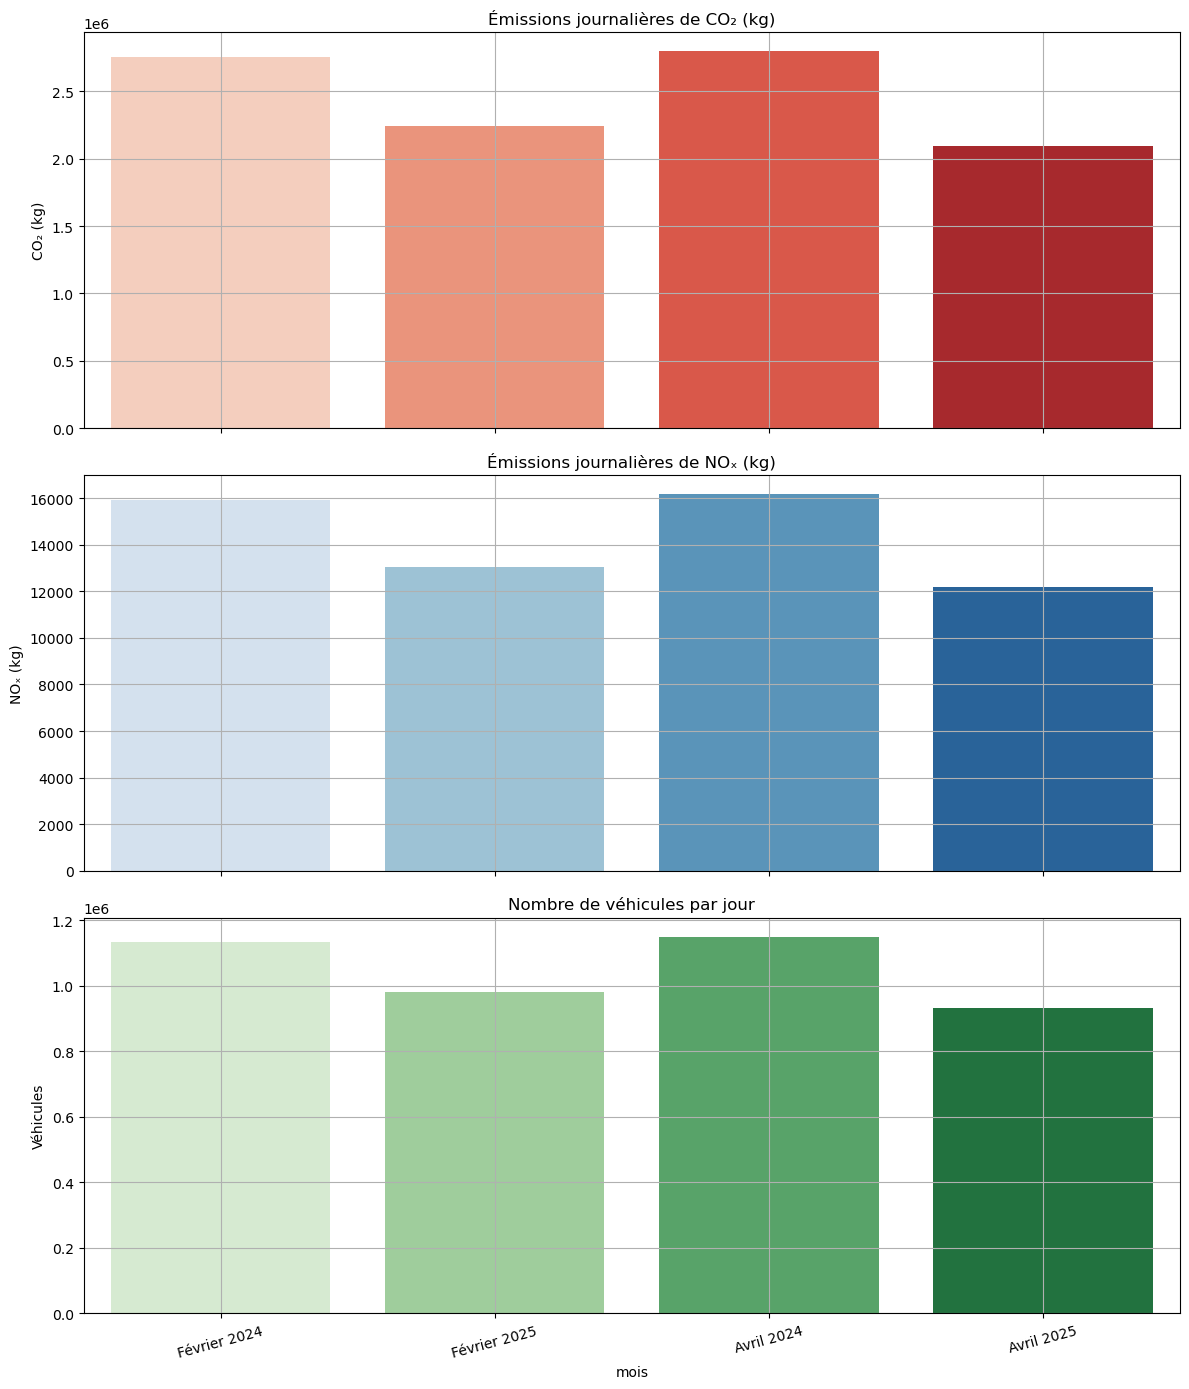

In [9]:
# Création d'un graphique comparatif des émissions et des volumes de trafic

fig, axs = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# Barplot CO2
sns.barplot(data=df_resultats, x="mois", y="CO2_total_kg", ax=axs[0], palette="Reds")
axs[0].set_title("Émissions journalières de CO₂ (kg)")
axs[0].set_ylabel("CO₂ (kg)")
axs[0].grid(True)

# Barplot NOx
sns.barplot(data=df_resultats, x="mois", y="NOx_total_kg", ax=axs[1], palette="Blues")
axs[1].set_title("Émissions journalières de NOₓ (kg)")
axs[1].set_ylabel("NOₓ (kg)")
axs[1].grid(True)

# Barplot Nombre de voitures
sns.barplot(data=df_resultats, x="mois", y="nb_voitures", ax=axs[2], palette="Greens")
axs[2].set_title("Nombre de véhicules par jour")
axs[2].set_ylabel("Véhicules")
axs[2].grid(True)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


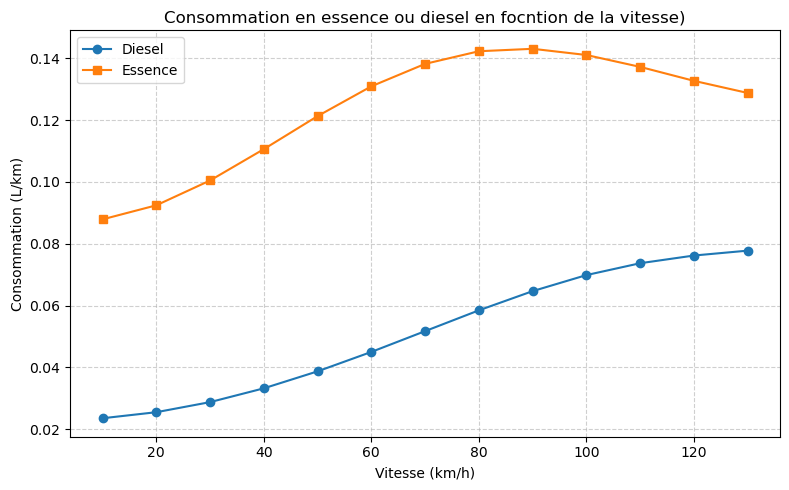

In [10]:

v_points = np.arange(10, 131, 10)
# Recalcul des consommations avec mu_P dynamique
conso_diesel_dyn = [conso_l_km_dyn_muP(v, params["diesel"]["eta0"],
                                       params["diesel"]["HL"], Pe, "diesel") for v in v_points]
conso_essence_dyn = [conso_l_km_dyn_muP(v, params["essence"]["eta0"],
                                        params["essence"]["HL"], Pe, "essence") for v in v_points]

# Nouveau graphique
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(v_points, conso_diesel_dyn, 'o-', label='Diesel', color='#1f77b4')
ax.plot(v_points, conso_essence_dyn, 's-', label='Essence', color='#ff7f0e')

ax.set_xlabel('Vitesse (km/h)')
ax.set_ylabel('Consommation (L/km)')
ax.set_title('Consommation en essence ou diesel en focntion de la vitesse)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

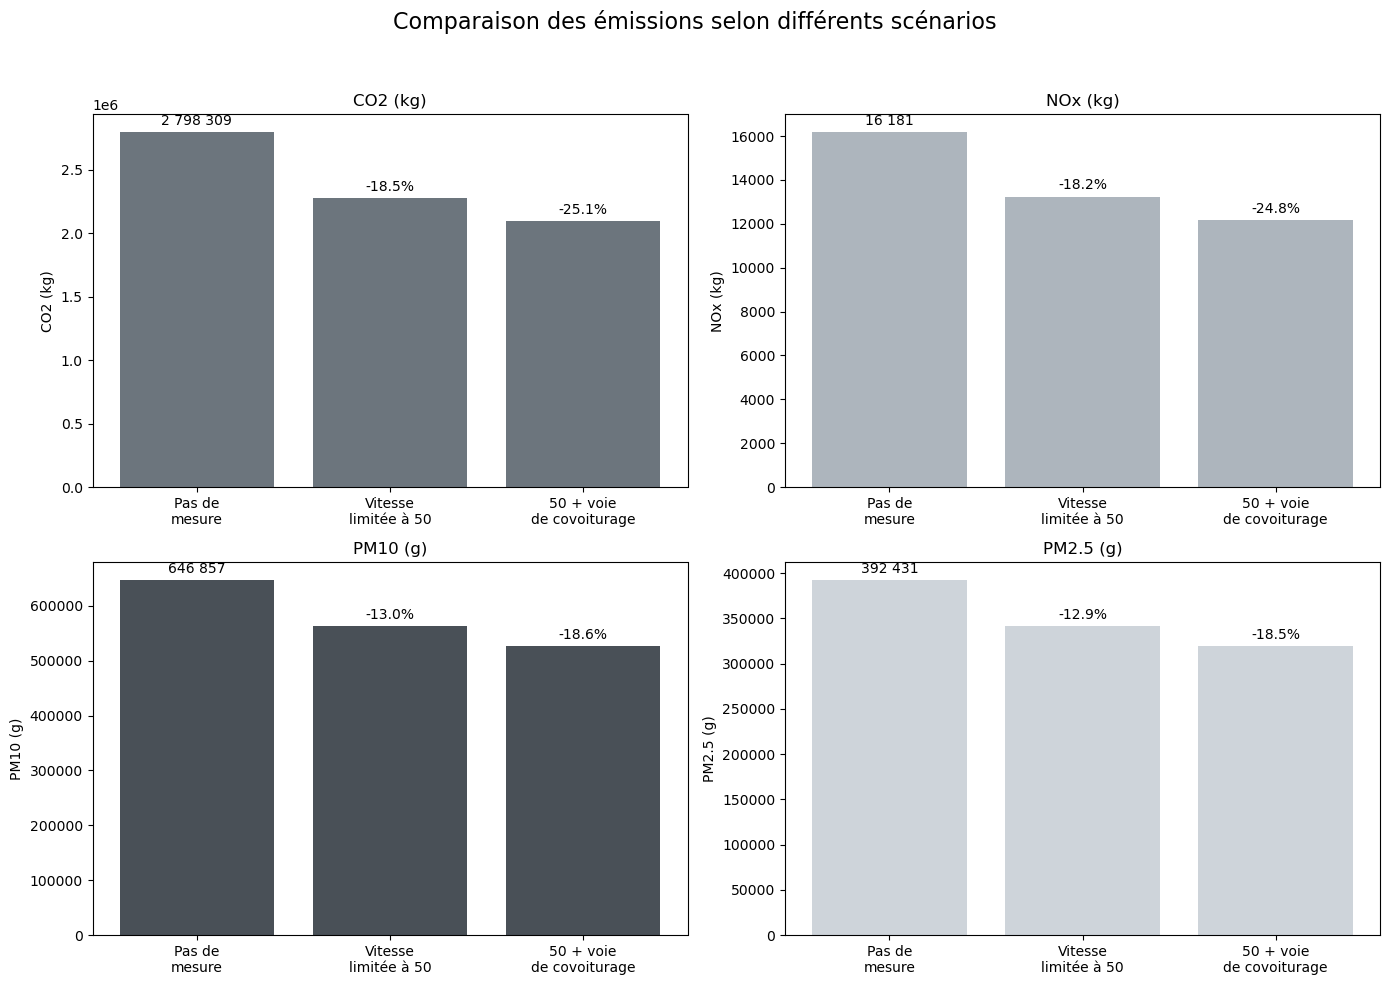

In [11]:
import matplotlib.pyplot as plt

# Filtrage des lignes pour chaque mois
fev24 = df_resultats[df_resultats["mois"] == "Février 2024"].iloc[0]
fev25 = df_resultats[df_resultats["mois"] == "Février 2025"].iloc[0]
avr24 = df_resultats[df_resultats["mois"] == "Avril 2024"].iloc[0]
avr25 = df_resultats[df_resultats["mois"] == "Avril 2025"].iloc[0]

# Calcul des pourcentages de réduction entre février 2024 et février 2025
reduc_CO2 = (fev24["CO2_total_kg"] - fev25["CO2_total_kg"]) / fev24["CO2_total_kg"]
reduc_NOx = (fev24["NOx_total_kg"] - fev25["NOx_total_kg"]) / fev24["NOx_total_kg"]
reduc_PM10 = (fev24["PM10_total_g"] - fev25["PM10_total_g"]) / fev24["PM10_total_g"]
reduc_PM25 = (fev24["PM2.5_total_g"] - fev25["PM2.5_total_g"]) / fev24["PM2.5_total_g"]

# Calcul des valeurs réduites pour avril 2024
valeurs = {
    "CO2 (kg)": [avr24["CO2_total_kg"], avr24["CO2_total_kg"] * (1 - reduc_CO2), avr25["CO2_total_kg"]],
    "NOx (kg)": [avr24["NOx_total_kg"], avr24["NOx_total_kg"] * (1 - reduc_NOx), avr25["NOx_total_kg"]],
    "PM10 (g)": [avr24["PM10_total_g"], avr24["PM10_total_g"] * (1 - reduc_PM10), avr25["PM10_total_g"]],
    "PM2.5 (g)": [avr24["PM2.5_total_g"], avr24["PM2.5_total_g"] * (1 - reduc_PM25), avr25["PM2.5_total_g"]],
}

x_labels = ["Pas de\nmesure", "Vitesse\nlimitée à 50", "50 + voie\nde covoiturage"]

# Style sobre
plt.style.use('default')
colors = ["#6C757D", "#ADB5BD", "#495057", "#CED4DA"]

# Création des subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Comparaison des émissions selon différents scénarios", fontsize=16)

for ax, (polluant, vals), color in zip(axes.flat, valeurs.items(), colors):
    bars = ax.bar(x_labels, vals, color=color)
    ax.set_title(polluant)
    ax.set_ylabel(polluant)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if i == 0:
            label = f"{int(height):,}".replace(",", " ")
        else:
            pct_reduc = 100 * (1 - (height / vals[0]))
            label = f"-{pct_reduc:.1f}%"
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02 * max(vals), label, ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
